In [323]:
#from google.colab import drive
#drive.mount('/content/drive')
#Used this for google colab, but ran SO SLOWLY.

In [0]:
#zip_path = '/content/drive/My Drive/DST Assessment 5/SOCOFing.zip'
#extract_to = '/content/drive/My Drive/DST Assessment 5/SOCOFing'

#!unzip -uq '/content/drive/My Drive/DST Assessment 5/SOCOFing.zip' -d '/content/drive/My Drive/DST Assessment 5/SOCOFing'

In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import time

import os
import cv2
import random

import matplotlib.pyplot as plt

import keras
from keras.models import load_model
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.callbacks import ModelCheckpoint, EarlyStopping 

#from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import RMSprop
#from keras.layers.normalization import BatchNormalization
#from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [8]:
def extract_label(img_path,train = True):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')
    
    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')
    
    gender = 0 if gender == 'M' else 1
    lr = 0 if lr == 'Left' else 1

    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4
        
    return np.array([subject_id, gender, lr, finger], dtype=np.uint16)

In [9]:
# Very likely need to change label[3] so that we have more features.

img_size = 96

def loading_data(path,train):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            data.append([label, img_resize ])
        except Exception as e:
            pass
    data
    return data

In [13]:
time_start = time.time()

Real_path = "SOCOFing/Real"
Easy_path = "SOCOFing/Altered/Altered-Easy"
Medium_path = "SOCOFing/Altered/Altered-Medium"
Hard_path = "SOCOFing/Altered/Altered-Hard"


Easy_data = loading_data(Easy_path, train = True)
Medium_data = loading_data(Medium_path, train = True)
Hard_data = loading_data(Hard_path, train = True)
test = loading_data(Real_path, train = False)

data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)

del Easy_data, Medium_data, Hard_data

time.time()-time_start

loading data from:  SOCOFing/Altered/Altered-Easy
loading data from:  SOCOFing/Altered/Altered-Medium
loading data from:  SOCOFing/Altered/Altered-Hard
loading data from:  SOCOFing/Real


4.791997909545898

In [73]:
#Let's take a quick look at this, we have the subject_id, gender, lr, finger.
#Here, for each data point, [1] contains the image and [0] contains the list of features.
#Now we can choose what we want to recognise

test_df2 = pd.DataFrame(test, columns = ['labels', 'image'])
test_df = pd.DataFrame(test_df2.labels.tolist(), columns=['id', 'gender', 'lr', 'finger'], index= test_df2.index)
test_df['image'] = df2['image']
display(test_df)

train_df2 = pd.DataFrame(data, columns = ['labels', 'image'])
train_df = pd.DataFrame(train_df2.labels.tolist(), columns=['id', 'gender', 'lr', 'finger'], index= train_df2.index)
train_df['image'] = train_df2['image']
display(train_df)

,id,gender,lr,finger,image
0,364,0,1,4,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
1,292,0,0,4,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
2,53,0,0,0,"[[117, 114, 114, 111, 111, 111, 111, 111, 111,..."
3,225,0,0,4,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
4,277,0,1,2,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
...,...,...,...,...,...
5995,440,0,0,0,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
5996,43,1,1,3,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
5997,303,1,1,1,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
5998,102,0,1,3,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."


,id,gender,lr,finger,image
0,247,0,0,1,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
1,242,0,0,4,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
2,128,0,0,2,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
3,202,0,0,1,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
4,465,1,1,1,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
...,...,...,...,...,...
49265,493,0,1,4,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
49266,52,0,1,4,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
49267,2,1,0,4,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."
49268,165,0,0,2,"[[160, 158, 158, 158, 158, 158, 158, 158, 158,..."


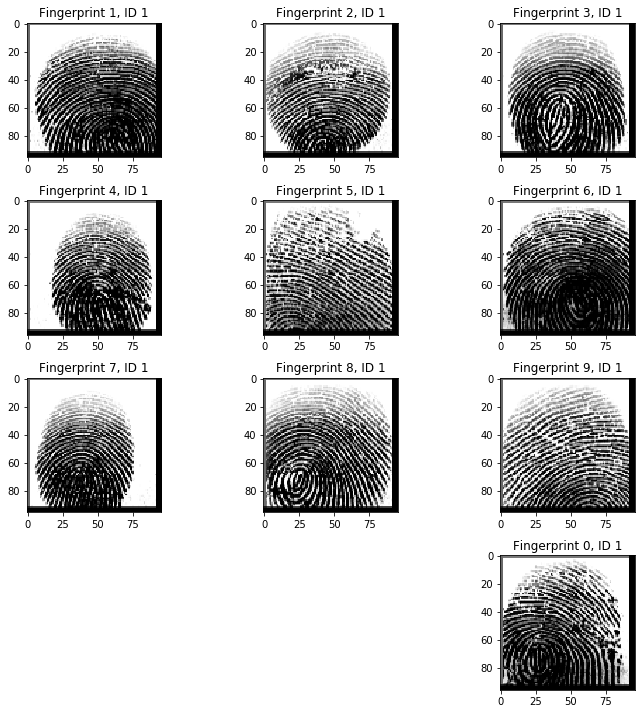

In [322]:
dfid1 = test_df[test_df['id']==1]
dfid1

plt.figure(figsize=[10,10])

for i in range(len(dfid1)):
    position = ('43' + str(i))
    
    plt.subplot(position)
    plt.imshow(dfid1['image'].iloc[i], cmap='gray')
    plt.title('Fingerprint ' + str(i) + ', ID ' + str(1))
    plt.tight_layout(pad=1.0)
    

Let's see if we can determine using our training data, which hand was used to take the fingerprints. We will train on the training set, and then use our test set for measuring. We will need to make sure that we only take the 'finger' labels from our data. Since the images are grayscale we will normalise them by dividing by 255. We will use the np reshape command to turn our images from vectors into matrices.

In [79]:
test_lrdf = test_df.drop(['id', 'gender', 'finger'], axis = 1)
test_lr = test_lrdf.to_numpy()

train_lrdf = train_df.drop(['id', 'gender', 'finger'], axis = 1)
train_lr = train_lrdf.to_numpy()

In [80]:
#can del data after running this to free up space.
img_size = 96
X, y = [], []

for label, feature in train_lr:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0

y = to_categorical(y, num_classes = 2)

In [81]:
#can del test after running this to free up space.
img_size = 96
X_test, y_test = [], []

for label, feature in test_lr:
    X_test.append(feature)
    y_test.append(label)
    
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_test = to_categorical(y_test, num_classes = 2)

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [93]:
print('Original label:', test_lr[0][0])
print('After conversion to one-hot:', y_test[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [99]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((39416, 96, 96, 1), (9854, 96, 96, 1), (39416, 2), (9854, 2))

We can see that the one-hot encoding worked, and that we now have the right shape for our data. X_train has 39416 images that are each sized 96x96 pixels. X_val has 9854 images with 96x96 pixels in. y_train and y_val have the corresponding number of labels, each with a vector of size 2 that has the one hot encoded labelled values.

In [139]:
#If we have more memory, increasing batch_size will increase learning parameters, but requires more memory.

batch_size = 64
epochs = 2
num_classes = 2

In [140]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(img_size,img_size,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [141]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


In [142]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
model_train = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val))


In [116]:
test_eval = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.08633177168667316
Test accuracy: 0.9674999713897705


Pretty good accuracy straight off the bat, this improves to over 99.8% accuracy on both test set and validation set if you train for ~20 epochs. Before we do that again, and to condense this a little more, I'm going to add in callbacks before we get there. 

There didn't look like overfitting, so I guess we don't need to use a Dropout layer.

We can set the model to stop if there is no improvement in val_loss over 5 epochs. Apparently val_loss is a better stop for early stopping.
We can set the model to save at the epoch that had the greatest val_accuracy.

In [137]:
#consider changing batch size, and leaving to run longer. I've used val_loss instead of val_accuracy for EarlyStopping.
batch_size = 64
epochs = 20
num_classes = 2

mc = ModelCheckpoint('best_fpmodel.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks = [mc, es]

# Please feel free to skip this step and use the model that's saved. It has been saved from the checkpoint callback. It'll save over an hour of model fitting on your computer.

In [138]:
model_train = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val), callbacks=callbacks)


Train on 39416 samples, validate on 9854 samples
Epoch 1/20
39416/39416 [==============================] - 226s 6ms/step - loss: 0.3265 - accuracy: 0.8509 - val_loss: 0.2035 - val_accuracy: 0.9185

Epoch 00001: val_accuracy improved from -inf to 0.91851, saving model to best_fpmodel.h5
Epoch 2/20
39416/39416 [==============================] - 222s 6ms/step - loss: 0.1589 - accuracy: 0.9369 - val_loss: 0.0840 - val_accuracy: 0.9715

Epoch 00002: val_accuracy improved from 0.91851 to 0.97148, saving model to best_fpmodel.h5
Epoch 3/20
39416/39416 [==============================] - 214s 5ms/step - loss: 0.0583 - accuracy: 0.9782 - val_loss: 0.0515 - val_accuracy: 0.9837

Epoch 00003: val_accuracy improved from 0.97148 to 0.98366, saving model to best_fpmodel.h5
Epoch 4/20
39416/39416 [==============================] - 217s 5ms/step - loss: 0.0243 - accuracy: 0.9922 - val_loss: 0.0397 - val_accuracy: 0.9854

Epoch 00004: val_accuracy improved from 0.98366 to 0.98539, saving model to best_f

In [146]:
model = load_model('best_fpmodel.h5')

In [147]:
test_eval = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.004519075815956663
Test accuracy: 0.9993333220481873


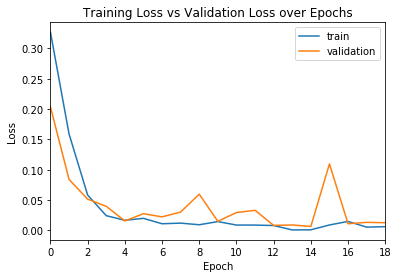

In [160]:
plt.plot(model_train.history['loss'], label='train')
plt.plot(model_train.history['val_loss'], label='validation')
plt.xlim(0,18)
plt.legend()
plt.title('Training Loss vs Validation Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

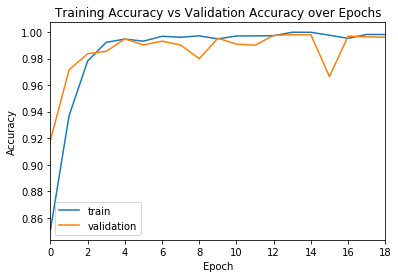

In [163]:
plt.plot(model_train.history['accuracy'], label='train')
plt.plot(model_train.history['val_accuracy'], label='validation')
plt.xlim(0,18)
plt.legend()
plt.title('Training Accuracy vs Validation Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

We could add Dropout layers to make sure that our model doesn't overfit. Typically they are added with model.add(Dropout(0.25)). These are added between MaxPooling and Conv2d layers.

In [211]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [212]:
predicted_classes

array([1, 0, 0, ..., 1, 1, 0])

In [213]:
y_classes = np.argmax(np.round(y_test),axis=1)
y_classes

array([1, 0, 0, ..., 1, 1, 0])

In [214]:
correct = np.where(predicted_classes == y_classes)[0]
print('Found %d correct labels' % len(correct))

Found 5996 correct labels


In [215]:
incorrect = np.where(predicted_classes!=y_classes)[0]
print('Found %d incorrect labels' % len(incorrect))

Found 4 incorrect labels


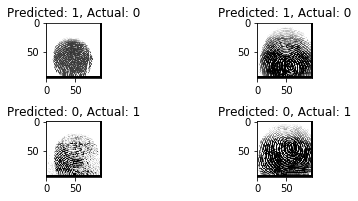

In [305]:
length = len(incorrect)
for i, incorrectn in enumerate(incorrect[:length]):
    plt.subplot(3,2,i+1)
    plt.imshow(X_test[incorrectn].reshape(img_size,img_size), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Actual: {}".format(predicted_classes[incorrectn], y_classes[incorrectn]))
    plt.tight_layout(1.0)

So the model is equally predicting errors between left and right. We could use some kind of Classification review on this, but we can see everything we need to here.

What's going on in this Model? Most of the time Deep Learning is thought of as a black box, and we can't understand what's actually happening, but we can look at the convolutional layers to find out how different convolutions run across images.

In [240]:
c1 = model.layers[0]
weights1 = c1.get_weights()

In [308]:
def convolution_layer1(image, i):
    kernel = weights1[0][...,0, i]
    kernel = kernel - kernel.mean()
    result = np.zeros(image.shape)

    for ii in range(image.shape[0]-3):
        for jj in range(image.shape[1]-3):
            result[ii, jj] = np.sum(image[ii:ii+3, jj:jj+3] * kernel)

    return result

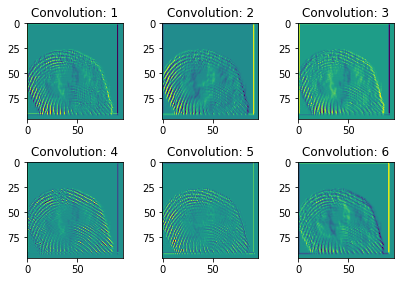

In [309]:
for i in range(6):
    plt.subplot(2,3,i+1)
    out = convolution_layer1(X_train[0, :, :, 0], i)
    plt.imshow(out)
    plt.title("Convolution: {}".format(i+1))
    plt.tight_layout(pad=1.0)

In [315]:
c2 = model.layers[3]
weights2 = c2.get_weights()

In [316]:
def convolution_layer2(image, i):
    kernel = weights2[0][...,0, i]
    kernel = kernel - kernel.mean()
    result = np.zeros(image.shape)

    for ii in range(image.shape[0]-3):
        for jj in range(image.shape[1]-3):
            result[ii, jj] = np.sum(image[ii:ii+3, jj:jj+3] * kernel)

    return result

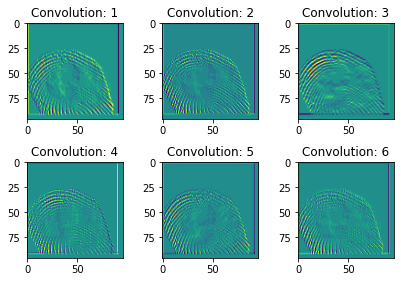

In [317]:
for i in range(6):
    plt.subplot(2,3,i+1)
    out = convolution_layer2(X_train[0, :, :, 0], i)
    plt.imshow(out)
    plt.title("Convolution: {}".format(i+1))
    plt.tight_layout(pad=1.0)